## Character-level recurrent sequence-to-sequence model

Example from https://keras.io/examples/nlp/lstm_seq2seq/  
Older post https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

In [13]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from itertools import chain
import tensorflow as tf
from tensorflow import keras
from Levenshtein import *
from tensorflow.keras.callbacks import EarlyStopping

In [14]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 8)

In [15]:
with np.load('data/ncbi_02/dataset.npz', allow_pickle = True) as data:
    encoder_input_data = data['encoder_input_data']
    decoder_input_data = data['decoder_input_data']
    decoder_target_data = data['decoder_target_data']
    token_index = data['token_index'].tolist()

In [16]:
print(encoder_input_data.shape)
print(decoder_input_data.shape)
print(token_index)

(4368, 3822, 4)
(4368, 3822, 4)
{'A': 0, 'C': 1, 'G': 2, 'T': 3}


## Inference

In [17]:
model = keras.models.load_model("data/ncbi_02/06-ncbi-lstm-att-batch-model")
model.summary()

2022-03-29 09:35:38.474133: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_SYSTEM_DRIVER_MISMATCH: system has unsupported display driver / cuda driver combination
2022-03-29 09:35:38.474157: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: mif325-gpu2
2022-03-29 09:35:38.474163: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: mif325-gpu2
2022-03-29 09:35:38.474211: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.54.0
2022-03-29 09:35:38.474230: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.47.3
2022-03-29 09:35:38.474236: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 510.47.3 does not match DSO version 510.54.0 -- cannot find working devices in this configuration
2022-03-29 09:35:38.474397: I tensorflow/core/platform/cpu_feature_guard.cc:151] This Tens

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3822, 4)]    0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 3822, 64),   17664       ['input_1[0][0]']                
                                 (None, 64),                                                      
                                 (None, 64)]                                                      
                                                                                                  
 batch_normalization (BatchNorm  (None, 64)          256         ['lstm[0][1]']                   
 alization)                                                                                   

In [18]:
reverse_char_index = dict((i, char) for char, i in token_index.items())
decode_seq = lambda seq: [ ''.join([ reverse_char_index[i] for i in s ]) for s in np.argmax(seq, axis = 2)]

In [19]:
decode_seq(model.predict(encoder_input_data[0:1,:,:]))

['ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTTTTAATTTTAAAACCAAAAAAAAATAACCCCCGTTTAAAAAAATTTTTTCCCACCGGGGTTTTTTTTTCCCAAAAAATTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT

In [25]:
output_seqs = model.predict(encoder_input_data)

2022-03-29 09:37:52.847518: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1869783552 exceeds 10% of free system memory.
2022-03-29 09:37:53.898706: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1869783552 exceeds 10% of free system memory.
2022-03-29 09:37:54.948917: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1869783552 exceeds 10% of free system memory.
2022-03-29 09:37:56.017275: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1869783552 exceeds 10% of free system memory.
2022-03-29 09:37:57.072281: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1869783552 exceeds 10% of free system memory.


In [21]:
output_seqs = decode_sequence_batch(encoder_input_data)

# with open('data/ncbi_02/predicted_256_gru.npy', 'wb') as f:
#     np.save(f, output_seqs)
    
#     d = keras.losses.CategoricalCrossentropy()(target_seq, output_seq).numpy()
#     print(f"{i}. {d}")

NameError: name 'decode_sequence_batch' is not defined

## Metrics

In [26]:
keras.losses.CategoricalCrossentropy()(decoder_target_data, output_seqs).numpy()

1.3526609

In [27]:
cce = []
for i in range(len(decoder_target_data)):
    _ = keras.losses.CategoricalCrossentropy()(decoder_target_data[i:i + 1], output_seqs[i:i + 1]).numpy()
    cce.append(_)
cce = np.array(cce)

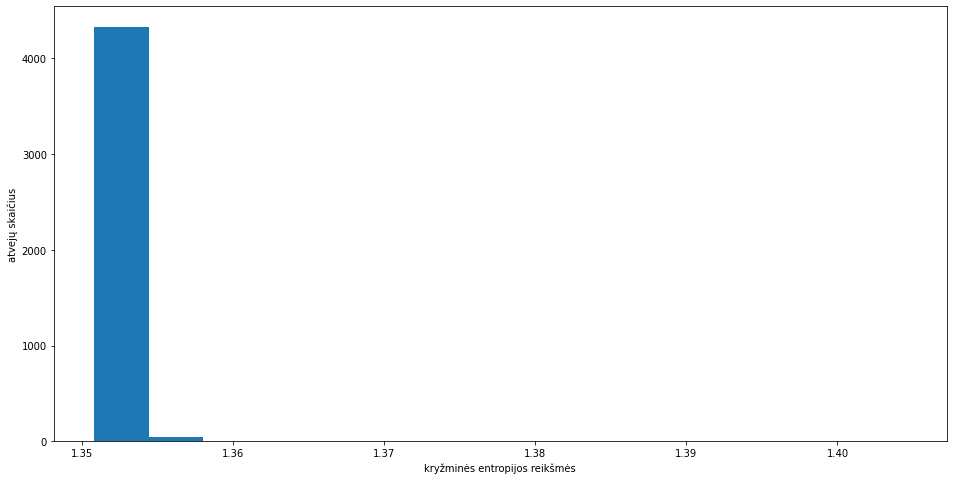

In [28]:
plt.hist(cce, bins = 15)
plt.xlabel('kryžminės entropijos reikšmės')
plt.ylabel('atvejų skaičius')
plt.show()

In [29]:
decoder_input_sequences = decode_seq(decoder_input_data)

In [30]:
decoder_target_sequences = decode_seq(decoder_target_data)
decoder_output_sequences = decode_seq(output_seqs)

In [31]:
lev_distances = [ distance(x,y) for x,y in zip(decoder_target_sequences, decoder_output_sequences) ]
lev_ratio = [ ratio(x,y) for x,y in zip(decoder_target_sequences, decoder_output_sequences) ]
ham_distances = [ hamming(x,y) for x,y in zip(decoder_target_sequences, decoder_output_sequences) ]

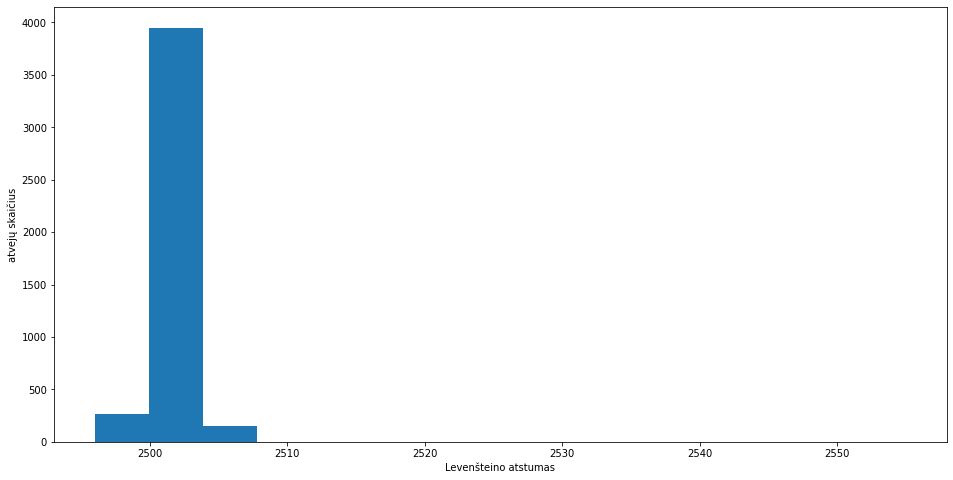

In [32]:
plt.hist(lev_distances, bins = 15)
plt.xlabel('Levenšteino atstumas')
plt.ylabel('atvejų skaičius')
plt.show()

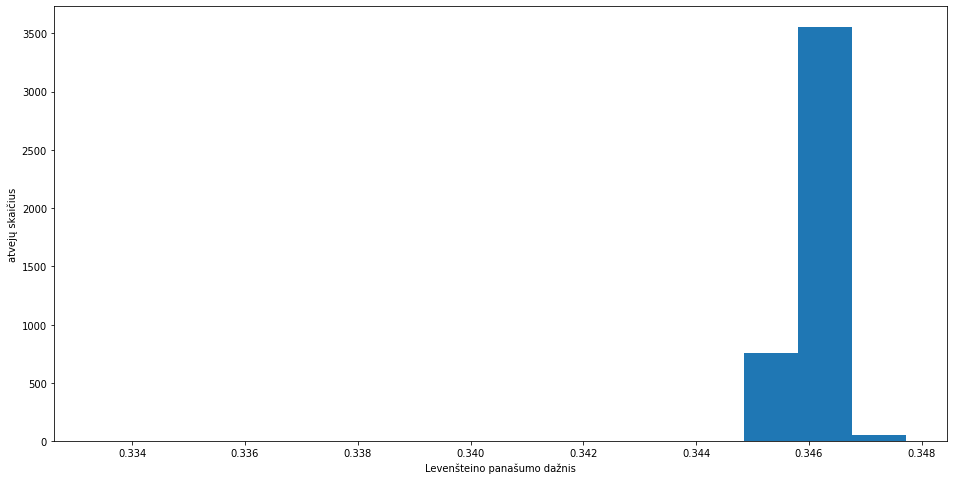

In [33]:
plt.hist(lev_ratio, bins = 15)
plt.xlabel('Levenšteino panašumo dažnis')
plt.ylabel('atvejų skaičius')
plt.show()

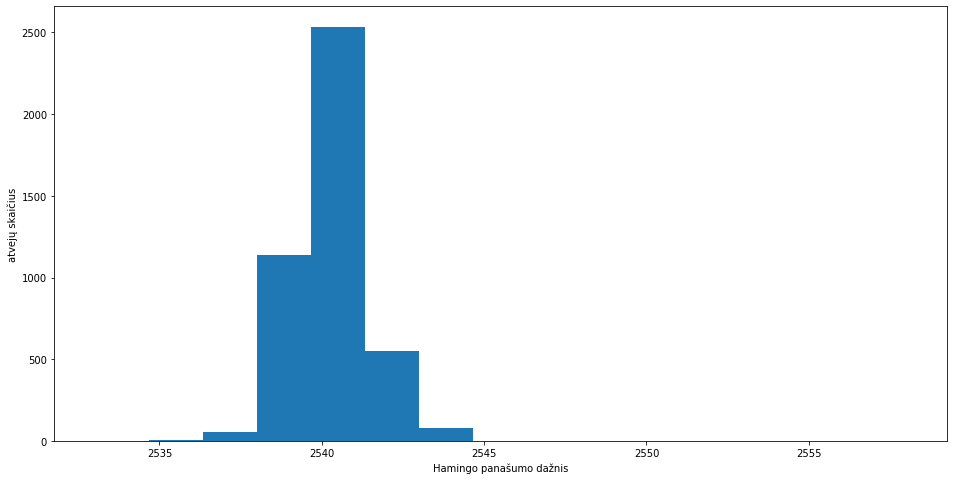

In [34]:
plt.hist(ham_distances, bins = 15)
plt.xlabel('Hamingo panašumo dažnis')
plt.ylabel('atvejų skaičius')
plt.show()

In [35]:
mut01 = np.sum(
    (np.subtract(
        np.argmax(encoder_input_data, axis = 2), 
        np.argmax(decoder_input_data, axis = 2)
    ) != 0.0).astype(int), axis = 0)

In [36]:
mut02 = np.sum(
    (np.subtract(
        np.argmax(decoder_target_data, axis = 2), 
        np.argmax(output_seqs, axis = 2)
    ) != 0.0).astype(int), axis = 0)

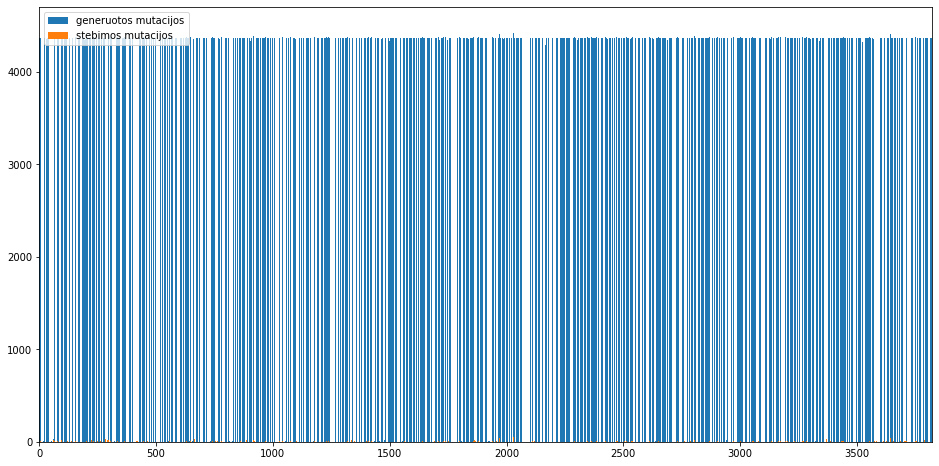

In [37]:
x_range = list(range(len(mut01)))
plt.bar(x_range, mut02, bottom = mut01, label = 'generuotos mutacijos')
plt.bar(x_range, mut01, label = 'stebimos mutacijos')
#plt.ylim(0, 200.0)
plt.xlim(0, len(mut01))
plt.legend()
plt.show()

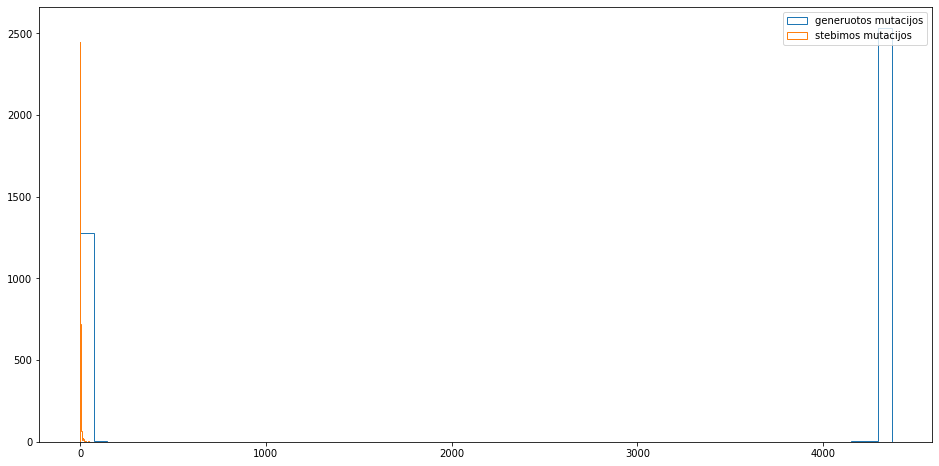

In [38]:
plt.hist(mut02, bins = 60, label = 'generuotos mutacijos', fill = False, histtype='step')
plt.hist(mut01, bins = 60, label = 'stebimos mutacijos', fill = False, histtype='step')
plt.legend()
plt.show()

In [ ]:
decoder_input_sequences[100]

In [ ]:
decoder_target_sequences[100]

In [ ]:
decoder_output_sequences[0]

In [11]:
latent_size = [ 32, 64 ]
accuracy = [ 0.28, 0.35 ]
seq_length = [ 83,  ]

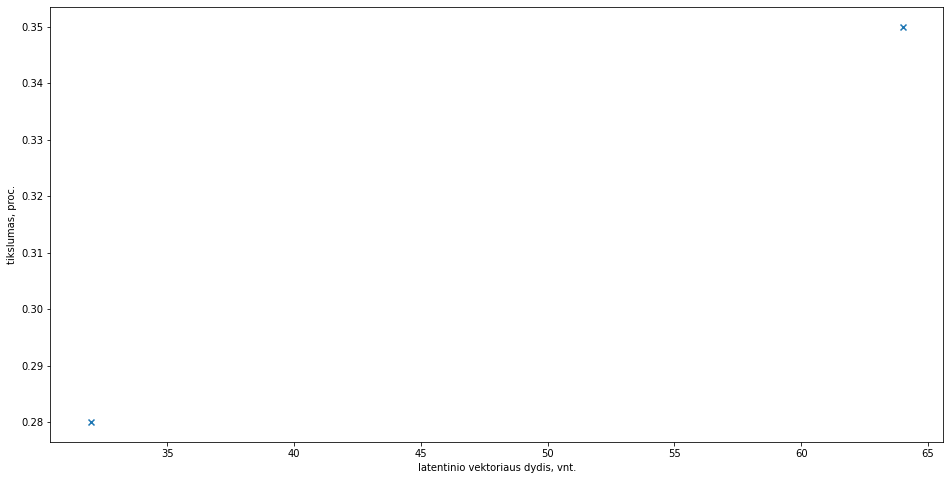

In [12]:
plt.scatter(latent_size, accuracy, marker='x')
plt.xlabel("latentinio vektoriaus dydis, vnt.")
plt.ylabel("tikslumas, proc.")
plt.show()

In [ ]:
latent_size = [ 32, 64 ]
accuracy = [ 0.28, 0.35 ]